# Programming Assignment: Building a Robust Data Pipeline

Welcome to the assignment for Data Management in PyTorch.

In earlier examples, you've worked with clean, pre-packaged datasets. In reality, data is rarely that simple. In computer vision, images often come in different sizes and formats and must be preprocessed before a model can learn from them. Manually handling this for thousands of images would be both tedious and error-prone.

In this assignment, you’ll work with the [Plants Classification](https://www.kaggle.com/datasets/marquis03/plants-classification) dataset, which contains 30,000 `.jpg` images across 30 plant species such as aloe vera, banana, spinach, and watermelon. Like many real-world datasets, the images vary in size and quality and are organized into folders by class. For this exercise, you’ll use a subset of 3,000 images.

This is where a data pipeline comes in. You’ll get hands-on experience building a custom dataset, applying the necessary transformations, and loading your data in batches. These are the essential first steps before training a deep learning model.

**What You will do in this Assignment**

* Access and explore the structure of an image dataset.
* Build a custom `Dataset` class to load your images and labels on demand.
* Define a series of `transformations`, including resizing, tensor conversion, and `normalization`, to preprocess the data.
* Define augmentation transforms to enhance the training dataset.
* Split the dataset into training, validation, and test sets applying the appropriate transforms to each and creating `DataLoader` instances for efficient batching.

Let's get started!

---
<a name='submission'></a>

<h4 style="color:green; font-weight:bold;">TIPS FOR SUCCESSFUL GRADING OF YOUR ASSIGNMENT:</h4>

* All cells are frozen except for the ones where you need to submit your solutions or when explicitly mentioned you can interact with it.

* In each exercise cell, look for comments `### START CODE HERE ###` and `### END CODE HERE ###`. These show you where to write the solution code. **Do not add or change any code that is outside these comments**.

* You can add new cells to experiment but these will be omitted by the grader, so don't rely on newly created cells to host your solution code, use the provided places for this.

* Avoid using global variables unless you absolutely have to. The grader tests your code in an isolated environment without running all cells from the top. As a result, global variables may be unavailable when scoring your submission. Global variables that are meant to be used will be defined in UPPERCASE.

* To submit your notebook for grading, first save it by clicking the 💾 icon on the top left of the page and then click on the `Submit assignment` button on the top right of the page.
---

## Table of Contents
- [Imports](#imports)
- [1 - Data Access](#1---data-access)
    - [1.1 - Exploring the Dataset](#11---exploring-the-dataset)
    - [1.2 - Creating a Custom Dataset Class](#12---creating-a-custom-dataset-class)
        - **[Exercise 1 - PlantsDataset](#exercise-1---plantsdataset)**
    - [1.3 - Overview of the images in the dataset](#13---overview-of-the-images-in-the-dataset)
- [2 - Transformations](#2---transformations)
    - [2.1 - Computing Mean and Standard Deviation](#21---computing-mean-and-standard-deviation)
    - [2.2 - Defining Transformations](#22---defining-transformations)
        - **[Exercise 2 - get_transformations](#exercise-2---get_transformations)**
- [3 - Data Loading](#3---data-loading)
    - **[Exercise 3 - get_data_loaders](#exercise-3---get_data_loaders)**

<a name='imports'></a>
## Imports

In [121]:
import pandas as pd
import torch
from torch.utils.data import Dataset, Subset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import os

In [122]:
import helper_utils
import unittests

<a name='1---data-access'></a>
## 1 - Data Access 

<a name='11---exploring-the-dataset'></a>
### 1.1 - Exploring the Dataset

As you’ve already learned, the first step when working with any new dataset is to explore it. This involves understanding its structure, the types of data it contains, and identifying any potential issues such as missing values or outliers.

In this step, you’ll use the `print_data_folder_structure` function from `helper_utils` to print the dataset's folder layout. 
This will help you see how the files and directories are organized, a crucial step before you start loading and preprocessing the data.

In [123]:
data_path = './data'
test_dataset_path = f'{data_path}/test'
train_dataset_path = f'{data_path}/train'
val_dataset_path = f'{data_path}/val'

# helper_utils.print_data_folder_structure(test_dataset_path, max_depth=1)
# helper_utils.print_data_folder_structure(train_dataset_path, max_depth=1)
# helper_utils.print_data_folder_structure(val_dataset_path, max_depth=1)

You now have an initial understanding of the dataset structure:
- `df_labels.csv`,
- `classname.txt`,
- One folder per class, each containing the images for that class (all in `.jpg` format).

This information will be useful when you design your custom Dataset class later on.

In [124]:
# print the content of `df_labels.csv`
test_df_labels = pd.read_csv(f'{data_path}/test.csv')
train_df_labels = pd.read_csv(f'{data_path}/train.csv')
val_df_labels = pd.read_csv(f'{data_path}/val.csv')
# print(test_df_labels.head())
# print(train_df_labels.head())
# print(val_df_labels.head())

In [125]:
# print the content of `class_names.txt`
with open(f'{test_dataset_path}/classname.txt', 'r') as f:
    class_names = f.read().splitlines()
# print(class_names)

You’ve verified that `labels.csv` contains the labels for each image along with their corresponding file names, and that `classname.txt` contains the names of all the classes.

<a name='12---creating-a-custom-dataset-class'></a>
### 1.2 - Creating a Custom Dataset Class

It is now time to create a custom dataset class to handle the plant images dataset. 
This class will inherit from `torch.utils.data.Dataset` and will be responsible for loading and preprocessing the images along with their corresponding labels.

<a name='exercise-1---plantsdataset'></a>
#### **Exercise 1 - `PlantsDataset`**

**Your Task:**

Your task is to complete the implementation of the custom PyTorch Dataset class `PlantsDataset`. 
You need to implement the missing code in multiple sections within the class:

* **Complete the `__init__` method**:
    * Load labels from the DataFrame using the already defined `load_labels` method on the `.df_info` attribute.
    * Create a mapping from label integers to class names using the already defined `read_classname` method.

* **Complete the `__len__` method**:
    * Return the total number of samples in the dataset by extracting the length of the `.labels` attribute.

* **Complete the `__getitem__` method**:
    * Retrieve the image at the specified index using the existing `retrieve_image` method.
    * Apply transformations to the image if they are specified.
    * Get the corresponding label from the `.labels` attribute.

<details>
  <summary><b><font color="green">Additional Code Hints (Click to expand if you are stuck)</font></b></summary>
  
If you need a little help, here's a more detailed guide for each method:

**For the `__init__` method:**
* For `self.labels`: Call `self.load_labels()` to extract labels from the `self.df_info` DataFrame.

**For the `__len__` method:**
* Use the built-in `len()` function on `self.labels`.

**For the `__getitem__` method:**
* Use `self.retrieve_image(idx)` to get the image at the specified index.
* If `self.transform` is not None, apply it to the image using `self.transform(image)`.
* Get the label from `self.labels[idx]`.

</details>

In [126]:
class PlantsDataset(Dataset):
    """
    ExDataset is a custom PyTorch Dataset for loading images and their corresponding labels from a specified directory and CSV file.

    Args:
        root_dir (str): Root directory containing the dataset files, including 'classname.txt'.
        transform (callable, optional): Optional transform to be applied on a sample.

    Attributes:
        root_dir (str): Path to the root directory of the dataset.
        transform (callable): Transformations to apply to the images.
        df_info (pd.DataFrame): DataFrame containing image file names and category labels.
        labels (list): List of integer labels for each image.
        class_names (list): List of class names corresponding to label indices.
    """

    def __init__(self, root_dir, df_info,dataset_path, transform=None):
        """
        Initializes the dataset object.

        Args:
            root_dir (str): Path to the root directory containing the dataset.
            transform (callable, optional): Optional transform to be applied on a sample.
        """

        # Initialize path to root directory and transformations
        self.root_dir = root_dir
        self.transform = transform

        # Read the CSV file (with images path and category labels)
        self.df_info = df_info

        ### START CODE HERE ###

        # Load labels from the DataFrame using the `load_labels` method
        self.labels = self.load_labels(self.df_info)

        # Create a mapping from label integers to class names using the `read_classname` method
        self.class_names = self.read_classname(dataset_path)
        # Initialize a list to keep track of any errors encountered.
        self.error_logs = []

        ### END CODE HERE ###

    # def read_df(self, csv_path):
    #     """
    #     Reads a CSV file from the specified path and returns it as a pandas DataFrame.
    #     """
    #     df = pd.read_csv(csv_path)
    #     return df

    def read_classname(self, dataset_path):
        """
        Reads class names from a file named 'classname.txt' located in the root directory.

        Returns:
            list: A list of class names, each as a string, read from the file.
        """
        path_txt = self.root_dir +"/"+ dataset_path + "/classname.txt"
        with open(path_txt, "r") as f:
            class_names = f.read().splitlines()
        return class_names

    def load_labels(self, df):
        """
        Extracts label integers from a DataFrame and returns them as a list.
        """
        labels = []

        for idx, row in df.iterrows():
            label_int = row["category"]
            labels.append(label_int)
        return labels

    def get_label_description(self, label: int):
        """
        Returns the description of a class label.
        """
        description = self.class_names[label]
        return description

    def retrieve_image(self, idx: int):
        """
        Retrieves and returns from the folder the PIL image at the specified index.
        It converts the image to RGB mode.
        """
        img_path = self.root_dir + "/" + self.df_info.iloc[idx]["image:FILE"]
        with Image.open(img_path) as img:
            img.verify()
        # Re-open the image file after successful verification.
        image = Image.open(img_path)
        image.load()
        # Check if the image dimensions are below a minimum threshold.
        if image.size[0] < 32 or image.size[1] < 32:
            # Raise an error for images that are too small.
            raise ValueError(f"Image too small: {image.size}")
        # Check if the image is not in the RGB color mode.
        if image.mode != "RGB":
            # Convert the image to RGB.
            image = image.convert("RGB")
        # Return the fully loaded and validated image.
        return image

    ### START CODE HERE ###

    def __len__(self):
        """
        Returns the number of samples in the dataset.
        """
        # Return the total number of samples from the `.labels` attribute
        length = len(self.labels)
        return length

    def __getitem__(self, idx):
        """
        Retrieves the image and its corresponding label at the specified index.

        Args:
            idx (int): Index of the item to retrieve.

        Returns:
            tuple: A tuple (image, label) where:
                - image: The image at the given index, possibly transformed if a transform is specified.
                - label: The label corresponding to the image.
        """
        # Loop to attempt loading a valid sample, preventing an infinite loop.
        for attempt in range(len(self)):
            try:
                # Retrieve the image using the `retrieve_image` method
                image = self.retrieve_image(idx)
                 # Apply the specified transformations to the image, if any
                # The None of the if condition is not part of the exercise, leave it as is
                if self.transform is not None:
                    image = self.transform(image)

                # Retrieve the label from the `labels` attribute
                label = self.labels[idx]

                # Return the image and label
                return image, label  
            except Exception as e:
                # Log the error if an exception occurs.
                self.log_error(idx, e)
                # Skip to the next index if an error is encountered.
                idx = (idx + 1) % len(self)

       
    
    def log_error(self, idx, e):
        """
        Records the details of an error encountered during data loading.

        Args:
            
            e (Exception): The exception object that was raised.
        """
        # Construct the filename of the problematic image.
        img_name = self.df_info.iloc[idx]["image:FILE"]
        # Construct the full path to the image file.
        img_path = os.path.join(self.root_dir, img_name)
        # Append a dictionary with error details to the log.
        self.error_logs.append(
            {
                "index": idx,
                "error": str(e),
                "path": img_path if "img_path" in locals() else "unknown",
            }
        )
        # Print a warning to the console about the skipped image.
        print(f"Warning: Skipping corrupted image {idx}: {e}")

    def get_error_summary(self):
        """
        Prints a summary of all errors encountered during dataset processing.
        """
        # Check if the error log is empty.
        if not self.error_logs:
            # Print a message indicating the dataset is clean.
            print("No errors encountered - dataset is clean!")
        else:
            # Print the total number of problematic images found.
            print(f"\nEncountered {len(self.error_logs)} problematic images:")
            # Iterate through the first few logged errors.
            for error in self.error_logs[:5]:
                # Print the details of an individual error.
                print(f"  Index {error['index']}: {error['error']}")
            # Check if there are more errors than were displayed.
            if len(self.error_logs) > 5:
                # Print a summary of the remaining errors.
                print(f"  ... and {len(self.error_logs) - 5} more")

    ### END CODE HERE ###

In [127]:
train_dataset = PlantsDataset(root_dir=data_path,df_info=train_df_labels,dataset_path="train", transform=None)
test_dataset = PlantsDataset(root_dir=data_path,df_info=test_df_labels,dataset_path="test", transform=None)
val_dataset = PlantsDataset(root_dir=data_path,df_info=val_df_labels,dataset_path="val", transform=None)

In [128]:
# print the length of the dataset
print(f'Length of the train dataset: {len(train_dataset)}')
print(f'Length of the train dataset: {len(test_dataset)}')
print(f'Length of the train dataset: {len(val_dataset)}')

Length of the train dataset: 21000
Length of the train dataset: 6000
Length of the train dataset: 3000


In [129]:
# Display the summary of any corrupted or problematic images found during loading.
train_dataset.get_error_summary()

No errors encountered - dataset is clean!


Description: galangal
Image shape: (1280, 720)


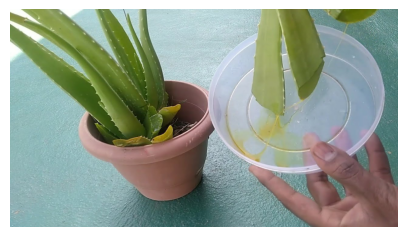

In [130]:
# Look at a sample to check it's working correctly
sel_idx = 10
img, label = train_dataset[sel_idx]

# Visualize the image
helper_utils.plot_img(img)

# Print its description
print(f'Description: {train_dataset.class_names[sel_idx]}')

# Print its shape
print(f'Image shape: {img.size}')  # PIL image size is (width, height)

##### **Expected Output**
```
Description: aloevera
Image shape: (269, 187)
```

![exp_out_1.png](exp_out_1.png)

<a name='13---overview-of-the-images-in-the-dataset'></a>
### 1.3 - Overview of the images in the dataset

The images are now accessible through the custom dataset class you implemented in the previous exercise. However, they haven’t been preprocessed yet, a necessary step before feeding them into a neural network.

In this step, you’ll explore the dataset using the `visual_exploration` function from `helper_utils`.
This function displays a few sample images along with their labels, allowing you to visually inspect the data and get a sense of its main characteristics.

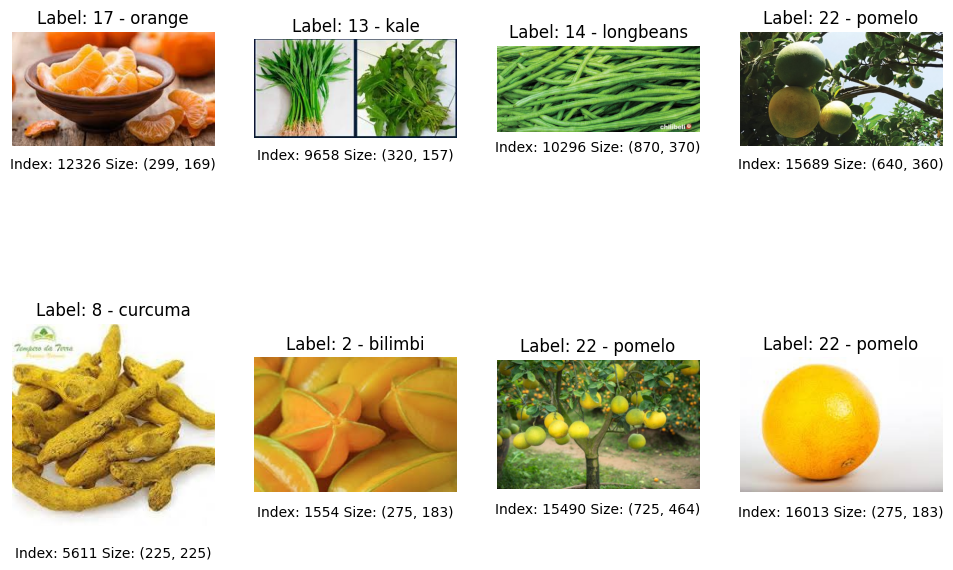

In [131]:
helper_utils.visual_exploration(train_dataset, num_rows=2, num_cols=4)

From the visual exploration, you can see that the images in the dataset vary in size, color, and background.
This kind of variability is common in real-world datasets and underscores the importance of preprocessing steps such as resizing, normalization, and data augmentation to help the model generalize effectively across different types of images.

<a name='2---transformations'></a>
## 2 - Transformations

Before feeding images into a neural network, you need to preprocess them using a series of transformations.
These steps include resizing the images to a consistent size, converting them into tensors, and normalizing their pixel values.

<a name='21---computing-mean-and-standard-deviation'></a>
### 2.1 - Computing Mean and Standard Deviation

Below is an auxiliary function, `get_mean_std`, that computes the mean and standard deviation of the dataset. Both values are needed for the normalization transformation later on.

The normalization transform will be applied after resizing and converting the images to tensors.
Since these two transformations change the pixel value distribution, it’s important to compute the mean and standard deviation after they are applied.

In `get_mean_std` you will:

* **Preprocessing Setup**: Create a transform pipeline that resizes images to 128×128 and converts PIL images to tensors.
* **Per-Image Processing**: Loop through each image in the dataset, applying the transforms and computing the mean and standard deviation across spatial dimensions (height/width) using `dim=[1, 2]`
* **Statistics Collection**: Store each image’s channel-wise statistics in separate lists (`means` and `stds`)
* **Global Calculation**: Stack all per-image statistics into tensors and average across all images to get dataset-wide channel statistics.

In [132]:
def get_dataset_mean_std(dataset: Dataset):
    # Define deterministic preprocessing (resize) + ToTensor
    preprocess = transforms.Compose(
        [transforms.Resize((128, 128)), transforms.ToTensor()]
    )
    means = []
    stds = []
    for img,_ in dataset:
        img_tensor = preprocess(img)
        means.append(img_tensor.mean(dim=[1, 2]))
        stds.append(img_tensor.std(dim=[1, 2]))
    mean = torch.stack(means).mean(dim=0)
    std = torch.stack(stds).mean(dim=0)
    return mean, std

In [133]:
train_mean, train_std = get_dataset_mean_std(train_dataset)
val_mean, val_std = get_dataset_mean_std(val_dataset)
test_mean, test_std = get_dataset_mean_std(test_dataset)

print(f"Train Mean: {train_mean}, Train Std: {train_std}")
print(f"Val Mean: {val_mean}, Val Std: {val_std}")
print(f"Test Mean: {test_mean}, Test Std: {test_std}")

Train Mean: tensor([0.6511, 0.6167, 0.4756]), Train Std: tensor([0.2127, 0.2166, 0.2568])
Val Mean: tensor([0.6659, 0.6203, 0.4784]), Val Std: tensor([0.2119, 0.2155, 0.2567])
Test Mean: tensor([0.6697, 0.6146, 0.4741]), Test Std: tensor([0.2108, 0.2191, 0.2587])


<a name='22---defining-transformations'></a>
### 2.2 - Defining Transformations

Having computed the mean and standard deviation of the dataset, you can now define the transformations to apply to the images.
You’ll create two sets of transformations: one for the training set, which includes data augmentation, and another for the validation and test sets.

<a name='exercise-2---get_transformations'></a>
#### **Exercise 2 - `get_transformations`**

**Your Task:**

Your task is to implement the missing code in the `get_transformations` function to create two image transformation pipelines for PyTorch. 

You will implement the following sections:

* **Define `main_tfs`**:
    * Create a `Resize` transform to resize images to 128x128 pixels.
    * Create a `ToTensor` transform to convert PIL images to PyTorch tensors.
    * Create a `Normalize` transform using the provided mean and standard deviation values.

* **Define `augmentation_tfs`**:
    * Create a `RandomVerticalFlip` transform with 50% probability.
    * Create a `RandomRotation` transform that rotates images by ±15 degrees.

* **Compose Transform Pipelines**:
    * Create `main_transform` by combining the main transforms into a single pipeline using `transforms.Compose`.
    * Create `transform_with_augmentation` by combining both augmentation and main transforms into an augmented pipeline.
    The augmentation transforms should be applied before the main transforms.


<details>
  <summary><b><font color="green">Additional Code Hints (Click to expand if you are stuck)</font></b></summary>

If you need a little help, here's a more detailed guide for each section:

**For `main_tfs`:**
* For `Resize`: Use `transforms.Resize((128, 128))` to resize all images to 128x128 pixels.
* For `ToTensor`: Use `transforms.ToTensor()` to convert PIL images to PyTorch tensors.
* For `Normalize`: Use `transforms.Normalize(mean=mean, std=std)` with the provided mean and std parameters.


**For `augmentation_tfs`:**
* For `RandomVerticalFlip`: Use `transforms.RandomVerticalFlip(p=0.5)` to flip images vertically with 50% probability.
* For `RandomRotation`: Use `transforms.RandomRotation(degrees=15)` to rotate images randomly within ±15 degrees.


**For composing transforms:**
* For `main_transform`: Use `transforms.Compose(main_tfs)` to combine the main transforms list.
* For `transform_with_augmentation`: Use `transforms.Compose(augmentation_tfs + main_tfs)` to combine both lists.

</details>

In [134]:
def get_augmentation_transform(mean, std):
    """
    Returns two sets of image transformation pipelines: one with basic preprocessing and another with additional data augmentation.

    Args:
        mean: Sequence of mean values for normalization.
        std: Sequence of standard deviation values for normalization.

    Returns:
        main_transform: Transformation pipeline with resizing, tensor conversion, and normalization.
        transform_with_augmentation: Transformation pipeline including random vertical flip, random rotation, resizing, tensor conversion, and normalization.
    """
    # Define a list of data augmentation transformations to be applied randomly.
    augmentations_transforms = [
        # Randomly flip the image horizontally with a 50% probability.
        transforms.RandomVerticalFlip(p=0.5),
        # Randomly rotate the image within a range of +/- 15 degrees.
        transforms.RandomRotation(degrees=15),
    ]
    
    # Define the main list of standard, non-random transformations.
    main_transforms = [
        # Resize images to 128x128 pixels
        transforms.Resize((128,128)),
        # Convert the PIL Image to a PyTorch tensor.
        transforms.ToTensor(),
        # Normalize the tensor with the provided mean and standard deviation.
        transforms.Normalize(mean=mean, std=std),
    ]
    main_tfs = transforms.Compose(main_transforms)

    # Combine the augmentation and main transformations into a single pipeline.
    augmentated_transforms = transforms.Compose(augmentations_transforms + main_transforms)
    return main_tfs, augmentated_transforms

In [135]:
# Get the transformations
_, train_transform_with_augmentation = get_augmentation_transform(train_mean, train_std)
val_main_transform,__ = get_augmentation_transform(val_mean, val_std)
test_main_transform,___ = get_augmentation_transform(test_mean, test_std)

# Print the transformations to verify
print(val_main_transform)
print(train_transform_with_augmentation)

Compose(
    Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=tensor([0.6659, 0.6203, 0.4784]), std=tensor([0.2119, 0.2155, 0.2567]))
)
Compose(
    RandomVerticalFlip(p=0.5)
    RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
    Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=tensor([0.6511, 0.6167, 0.4756]), std=tensor([0.2127, 0.2166, 0.2568]))
)


##### **Expected Output**

```
Compose(
    Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=tensor([0.6659, 0.6203, 0.4784]), std=tensor([0.2119, 0.2155, 0.2567]))
)
Compose(
    RandomVerticalFlip(p=0.5)
    RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
    Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=tensor([0.6659, 0.6203, 0.4784]), std=tensor([0.2119, 0.2155, 0.2567]))
)
```

You can verify your transformations by applying them to a sample image from the dataset and inspecting the result.

Transformed Image shape: torch.Size([3, 128, 128])


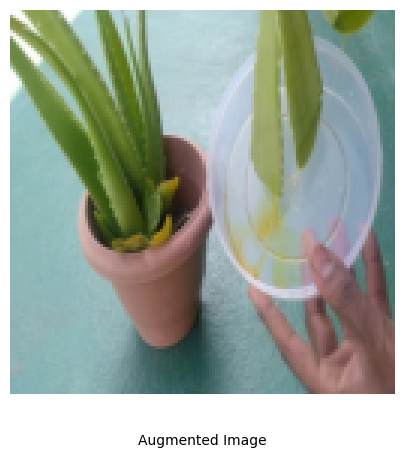

In [136]:
# Check main_transform on a sample image
img_transformed = test_main_transform(img)
print(f"Transformed Image shape: {img_transformed.shape}")


# get denormalization function
denormalize = helper_utils.Denormalize(train_mean, train_std)
# visualize the augmented image
img_augmented = train_transform_with_augmentation(img)
helper_utils.plot_img(denormalize(img_augmented), info=f"Augmented Image")

<a name='3---data-loading'></a>
## 3 - Data Loading

With your custom dataset class and transformations defined, you can now create data loaders to efficiently load and batch data for training and evaluation. This is the final step before you would train a neural network on this dataset.

As in the previous lab, after using `random_split` to divide the dataset into training, validation, and test sets, you need to ensure that each subset uses the appropriate transformations. 
One way to change the transformations of each subset is by wrapping the subsets in new instances of the custom dataset class `SubsetWithTransform`.

In [137]:
class SubsetWithTransform(PlantsDataset):
    """A subset of a dataset with a specific transform applied."""

    def __init__(self, *args, **kwargs):
         # Initialize the parent class with all provided arguments.
        super().__init__(*args, **kwargs)
        # Initialize a dictionary to count how many times each index is accessed.
        self.access_counts = {}
        # Initialize a list to store the load time for each access.
        self.load_times = []
        

    def __len__(self):
        return len(self.labels)


    def __getitem__(self, idx):
        """
        Retrieves a sample while monitoring access counts and load times.

        Args:
            idx (int): The index of the sample to retrieve.

        Returns:
            tuple: The data sample (e.g., image and label) from the parent class.
        """
        # Import the time module for timing operations.
        import time
        # Record the start time of the operation.
        start_time = time.time()
        # Increment the access count for the given index.
        self.access_counts[idx] = self.access_counts.get(idx, 0) + 1
        # Call the parent class's method to load the data.
       
        # Apply transform if provided
        result = super().__getitem__(idx)
        
        # Calculate the total time taken to load the sample.
        load_time = time.time() - start_time
        # Append the calculated load time to the list.
        self.load_times.append(load_time)
        # Check if the load time exceeds a certain threshold.
        if load_time > 1.0:
            # Print a warning if a slow load time is detected.
            print(f"⚠️ Slow load: Image {idx} took {load_time:.2f}s")
        # Return the loaded sample from the parent class.
        return result

    
    def print_stats(self):
        """
        Prints a summary of the dataset's access statistics and performance.
        """
        # Print a header for the statistics report.
        print("\n=== Pipeline Statistics ===")
        # Display the total number of images in the dataset.
        print(f"Total images: {len(self)}")
        # Display the number of unique images that were accessed.
        print(f"Unique images accessed: {len(self.access_counts)}")
        # Display the total number of errors logged by the parent class.
        print(f"Errors encountered: {len(self.error_logs)}")
        # Check if any load times have been recorded.
        if self.load_times:
            # Calculate the average load time.
            avg_time = sum(self.load_times) / len(self.load_times)
            # Find the maximum (slowest) load time.
            max_time = max(self.load_times)
            # Print the average load time in milliseconds.
            print(f"Average load time: {avg_time*1000:.1f} ms")
            # Print the slowest load time in milliseconds.
            print(f"Slowest load: {max_time*1000:.1f} ms")
        # Create a set of all possible indices in the dataset.
        all_indices = set(range(len(self)))
        # Create a set of all indices that were actually accessed.
        accessed_indices = set(self.access_counts.keys())
        # Find the set of indices that were never accessed.
        never_accessed = all_indices - accessed_indices
        # Check if there are any images that were never loaded.
        if never_accessed:
            # Print a warning message with the count of never-accessed images.
            print(f"\n⚠️ WARNING: {len(never_accessed)} images were never loaded!")
            # Show a few examples of the indices that were never accessed.
            print(f"   Examples: {list(never_accessed)[:5]}")

<a name='exercise-3---get_data_loaders'></a>
#### **Exercise 3 - `get_data_loaders`**

**Your Task:**

Your task is to complete the implementation of the `get_dataloaders` function to split a dataset and create PyTorch DataLoaders for training, validation, and testing. 
You need to implement the missing code in three main sections:

* **Split the Dataset**:
    * Use `random_split` to divide the dataset into training, validation, and test sets based on the calculated sizes.

* **Apply Transforms to Each Split**:
    * Wrap each dataset split with `SubsetWithTransform` to apply appropriate transforms.
    * Use `augmentation_transform` for the training set to include data augmentation.
    * Use `main_transform` for both validation and test sets (no augmentation needed).

* **Create DataLoaders**:
    * Create `DataLoader` objects for each dataset split with the specified batch size.
    * Enable shuffling for the training loader to randomize batch order.
    * Disable shuffling for validation and test loaders to maintain consistent evaluation.

<details>
  <summary><b><font color="green">Additional Code Hints (Click to expand if you are stuck)</font></b></summary>
  
If you need a little help, here's a more detailed guide for each section:

**For splitting the dataset:**
* Use `random_split(dataset, [train_size, val_size, test_size])` to split the dataset.

**For applying transforms:**
* Use `SubsetWithTransform(dataset_split, transform=transform_to_apply)` for each split.

**For creating DataLoaders:**
* Use `DataLoader(dataset=dataset_split, batch_size=batch_size, shuffle=shuffle_setting)`.
* For training loader: set `shuffle=True` to randomize the order of batches.
* For validation and test loaders: set `shuffle=False` to maintain consistent order for evaluation.
* All loaders should use the same `batch_size` parameter.

</details>

In [138]:
# GRADED FUNCTION : get_dataloaders
batch_size=32
train_dataset = SubsetWithTransform(root_dir=data_path, df_info=train_df_labels,dataset_path="train", transform=train_transform_with_augmentation)
val_dataset = SubsetWithTransform(root_dir=data_path, df_info=val_df_labels,dataset_path="val", transform=val_main_transform)
test_dataset = SubsetWithTransform(root_dir=data_path,df_info=test_df_labels,dataset_path="test", transform=test_main_transform)

# Create DataLoaders for each split
train_loader = DataLoader(train_dataset, batch_size=batch_size, 
                            shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, 
                            shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, 
                            shuffle=False)

In [139]:
for idx in range(len(val_dataset)):
    # Access the sample at the current index to trigger the monitoring and error-handling logic.
    img, label = val_dataset[idx]

val_dataset.print_stats()

print('=== Train Loader ===')
print(f"Number of batches in train_loader: {len(train_loader)}")
train_dataset = train_loader.dataset
print(f"Number of samples in train_dataset: {len(train_dataset)}")
print(f"Transforms applied to train_dataset: {train_dataset.transform}")
print(f"train_dataset type: {type(train_dataset)}")

print('\n=== Test Loader ===')
print(f"Number of batches in test_loader: {len(test_loader)}")
test_dataset = test_loader.dataset
print(f"Number of samples in test_dataset: {len(test_dataset)}")
print(f"Transforms applied to test_dataset: {test_dataset.transform}")
print(f"test_dataset type: {type(test_dataset)}")



=== Pipeline Statistics ===
Total images: 3000
Unique images accessed: 3000
Errors encountered: 0
Average load time: 2.0 ms
Slowest load: 67.3 ms
=== Train Loader ===
Number of batches in train_loader: 657
Number of samples in train_dataset: 21000
Transforms applied to train_dataset: Compose(
    RandomVerticalFlip(p=0.5)
    RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
    Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=tensor([0.6511, 0.6167, 0.4756]), std=tensor([0.2127, 0.2166, 0.2568]))
)
train_dataset type: <class '__main__.SubsetWithTransform'>

=== Test Loader ===
Number of batches in test_loader: 188
Number of samples in test_dataset: 6000
Transforms applied to test_dataset: Compose(
    Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=tensor([0.6697, 0.6146, 0.4741]), std=tensor([0.2108, 0.2191, 0.2587]))
)
tes

In [203]:
import torch.nn as nn

class PlantsClassifier(nn.Module):
    def __init__(self,num_classes=30):
        super(PlantsClassifier, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            # nn.Conv2d(128, 128, kernel_size=3, padding=1),
            # nn.ReLU(),
            # nn.MaxPool2d(2, 2),
        )
        
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)  # ✅ This should be 30, not 10!
        )
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

In [204]:

import torch.optim as optim

# check if GPU is available
device =torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
# initialize model and move it to the device
model = PlantsClassifier(num_classes=30).to(device)

# initialize loss function and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Using device: cpu


In [205]:
def train_epoch(model, train_loader, loss_function, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, targets)
        loss.backward()
        optimizer.step()
        #track metrics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += (predicted == targets).sum().item()
        total += targets.size(0)
        if batch_idx % 100 == 0 and batch_idx > 0:
            avg_loss = running_loss / 100
            accuracy = 100 * correct / total
            print(f"Loss: {avg_loss:.4f} | Accuracy: {accuracy:.2f}%")
            running_loss = 0.0
            correct = 0
            total = 0
            

In [206]:
def evaluate(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    
    accuracy = 100 * correct / total
    return accuracy
    

In [207]:
num_epochs = 10

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    # training model
    train_epoch(model, train_loader, loss_function, optimizer, device)
    
    # evaluate model
    accuracy = evaluate(model, val_loader, device)
    print(f"Test Accuracy: {accuracy:.2f}%")

Epoch 1/10
Loss: 3.2832 | Accuracy: 7.64%
Loss: 2.9852 | Accuracy: 12.31%
Loss: 2.8389 | Accuracy: 15.41%
Loss: 2.7150 | Accuracy: 18.84%
Loss: 2.6398 | Accuracy: 21.97%
Loss: 2.5177 | Accuracy: 24.25%
Test Accuracy: 26.30%
Epoch 2/10
Loss: 2.3999 | Accuracy: 29.24%
Loss: 2.2795 | Accuracy: 30.81%
Loss: 2.2380 | Accuracy: 32.59%
Loss: 2.2460 | Accuracy: 32.28%
Loss: 2.2067 | Accuracy: 33.44%
Loss: 2.1890 | Accuracy: 34.84%
Test Accuracy: 42.63%
Epoch 3/10
Loss: 2.0510 | Accuracy: 37.96%
Loss: 2.0060 | Accuracy: 39.97%
Loss: 2.0284 | Accuracy: 39.09%
Loss: 1.9576 | Accuracy: 40.75%
Loss: 1.9665 | Accuracy: 42.31%
Loss: 1.9617 | Accuracy: 40.38%
Test Accuracy: 50.47%
Epoch 4/10
Loss: 1.8662 | Accuracy: 44.77%
Loss: 1.8143 | Accuracy: 44.84%
Loss: 1.8228 | Accuracy: 46.59%
Loss: 1.7993 | Accuracy: 46.25%
Loss: 1.7784 | Accuracy: 45.97%
Loss: 1.7521 | Accuracy: 47.38%
Test Accuracy: 51.90%
Epoch 5/10
Loss: 1.6706 | Accuracy: 49.88%
Loss: 1.6762 | Accuracy: 49.50%
Loss: 1.6122 | Accuracy: 5